<h1><b>Statistique en Bioinformatique : </b> TME5 </h1><br>

L’objectif de ce TME est l'implementation de la méthode Expectation-Maximisation pour la recherche de motifs.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Soumission**</p>
<ul>
    <li>Le fichier doit être renommé selon le format: `NomEtudiant1_NomEtudiant2_TME5.ipynb`</li>
    <li>Envoyez-le par email à edoardo.sarti@upmc.fr avec l'objet "[SBAS-2019] TME5".</li>
    <li></li>
</ul>
</div>

Nom etudiant 1 : Alex YE
<br>
Nom etudiant 2 :
<br>

<H1>Expectation-Maximisation Motif</H1>
<br>
La méthode EM (Expectation-Maximisation) permet de détecter des motifs dans un ensemble de séquences ADN ou protéiques reliées, non alignées. En particulier, étant donné un groupe de séquences de longueur $L$, dont on sait qu'elles partagent un motif commun de longueur $w$, l’algorithme EM:
- infère un modèle $(\Theta,Z)$ pour le motif;
- localise l’occurrence du motif dans chaque séquence.

$\Theta$ representé la matrice des poids-positions $p_{c,k}$ du motif (où $c \in \{A,C,G,T\}$ ou $c \in \{A,C,D,...,W\}$  et $k \in \{0 \dots w\}$), $p_{c,0}$  est le vecteur de probabilités du modèle nul ou "background".
$Ζ$ est la matrice des variables cachées, qui donnent les positions initiales du motif: 
- $Z_{i,j} = 1$, si le motif commence en position $j$ de la séquence $i$,
- $Z_{i,j} = 0$, sinon. 

L’algorithme affine les paramètres du modèle de manière itérative par espérance-maximisation. Chaque itération $t$ se compose de deux étapes:
- (E) Calcul des valeurs attendues $Ζ^{(t)}$ de $Ζ$, étant donnés $\Theta^{(t-1)}$
- (M) Estimation de  $\Theta^{(t)}$  à partir de  $Ζ^{(t)}$

1\. Implémentez une fonction `read_training_file` pour lire le fichier d'entré qui contient un ensemble de séquences ADN non alignées. Pour simplifier nous allons utiliser les données vu en cours du fichier `toyEx.txt`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nts = ['A', 'C', 'G', 'T']

w = 3
input_f = "toyEx.txt"

def read_training_file(input_f):
    seqs = []
    with open(input_f, "r") as f:
        for line in f:
            seqs.append(line.strip())
    return np.array(seqs)

seqs = read_training_file(input_f)
print (seqs)

['GTCAGG' 'GAGAGT' 'ACGGAG' 'CCAGTC']


2\. Implémentez une fonction `initialiseP` pour initialiser la matrice poids-position $p_{c,k}$. On considère le modèle nul par défaut $p_0 = (0.25, 0.25, 0.25, 0.25)$. Pour initialiser $p^{(t)}$, on prend généralement un motif au hasard dans une sequence, et on fixe à $0.5$ les poids du nucleotide correspondant et à $\frac{1-0.5}{3}$ les trois autres. 

In [2]:
#initialiseP

p0 = np.array([0.25,0.25,0.25,0.25])

ind = np.random.randint(len(seqs[0])-w+1)
motif = [seqs[0][ind+it] for it in range(w)]

def initialiseP(null, w, seq, motif):
    weight = np.zeros( (4,w) ) 
    for j in range(w):
        c = motif[j]
        sel = nts.index(c)
        for i in range(4):
            if(i==sel):
                weight[i][j] = 0.5
            else:
                weight[i][j] = 0.5/3
    weight = np.array(weight)
    return np.vstack((null,weight.T)).T


p = initialiseP(p0, w, seqs[0], motif)
print( p )

[[0.25       0.16666667 0.16666667 0.5       ]
 [0.25       0.16666667 0.5        0.16666667]
 [0.25       0.16666667 0.16666667 0.16666667]
 [0.25       0.5        0.16666667 0.16666667]]


3\. Implémenter une fonction `initialiseZ` pour initialiser la matrice $Z$ à uns. Rappelez-vous que la dimension de $Z$ est $nbSeq \times (lenSeq -w +1)$, où $nbSeq$ est le nombre de sequences et $lenSeq$ est la taille/longueur des sequences.

In [3]:
#initialiseZ

def initialiseZ(seqs,w):
    z = np.ones( (len(seqs), len(seqs[0])-w+1) )    
    return z

Z = initialiseZ(seqs, w)
print( Z )

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


4\. Écrivez une fonction `E_step` pour le pas Expectation qui estime $Z$ à partir de  $p_{c,k}$. 
Écrivez aussi une fonction `normaliseZ` pour normaliser $Z$.

In [12]:
#E_step
def E_step(seqs,p,Z):
    zt = Z.copy()
    for i in range(len(zt)):
        for j in range(len(zt[i])):
            if(zt[i][j] == 1): # <== Z(maj) position possibles du motif, z(min) proba
                val = 1
                for k in range(len(seqs[i])):
                    c = nts.index(seqs[i][k])
                    if(k < j):
                        #hors motif
                        val *= p[c][0]
                    elif(k < j+w): 
                        #motif
                        val *= p[c][k-j+1]
                    else:
                        #hors motif
                        val *= p[c][0]
                zt[i][j] = val 
    return zt



#normaliseZ on rows
def normaliseZ(z):
    z2 = z.copy()
    for zi in z2:
        if(zi.sum() < 1):
            toDistr = 1 - zi.sum()
            for i in range(len(zi)):
                zi[i] += toDistr / len(zi)
        if(zi.sum() > 1):
            toDistr = abs(1 - zi.sum())
            for i in range(len(zi)):
                zi[i] -= toDistr / len(zi)
    return z2


z= E_step(seqs,p,Z) 
z= normaliseZ(z)

print(z)

[[0.2495298  0.25141059 0.2495298  0.2495298 ]
 [0.24996383 0.25010851 0.24996383 0.24996383]
 [0.25007234 0.24992766 0.25007234 0.24992766]
 [0.25043403 0.24985532 0.24985532 0.24985532]]


5\. Implémentez une fonction `M_step` pour le pas Maximisation qui estime $p_{c,k}$ à partir de $Z$. 
Utilisez les "pseudocounts" pour éviter les probabilités ègales à zero.

In [13]:
#normaliseP on columns
def normaliseP(p):
    p = p.copy()
    for j in range(np.size(p,1)):
        if(sum(p[:,j]) < 1):
            toDistr = 1 - sum(p[:,j])
            for i in range(len(p[:,j])):
                p[i,j] += toDistr / len(p[:,j])
        if(sum(p[:,j]) > 1):
            toDistr = abs(1 - sum(p[:,j]))
            for i in range(len(p[:,j])):
                p[i,j] -= toDistr / len(p[:,j])
    return p



def z_at_pos(seqs, char, z, pos):
    res = 0
    c = nts[char]
    for i in range(len(seqs)):
        for j in range(len(z[i])):
            ind = j+pos-1
            if(seqs[i][ind] == c):
                res+= z[i][j]
    return res

def count_at_pos(seqs, char, z, pos):
    res = 0
    c = nts[char]
    for i in range(len(seqs)):
        for j in range(1,len(z[i])):
            ind = j+pos-1
            if(seqs[i][ind] == c):
                res+= 1
    return res
   
    

#M_step
def M_step(seqs,p,z):
    pt = p.copy()
    all_occ = []
    for i in range(len(nts)):
        occ = 0
        for seq in seqs:
            occ += seq.count(nts[i])
        all_occ.append( occ )
        
    for c in range(len(pt)):
        for k in range(len(pt[c])):
            if(k>0):
                nck = z_at_pos(seqs,c, z, k)
            else:
                #probleme: nc < sum_j(n,j) --> proba < 0
                nck = all_occ[c] - sum([z_at_pos(seqs,c, z, pos) for pos in range(1,w+1)]) 
            pt[c][k] = (nck+1) / sum([zi.sum()+1 for zi in z])
    return pt

p= M_step(seqs,p,z)
p = normaliseP(p)
print(p)

[[0.18740054 0.28119123 0.28115506 0.25025318]
 [0.21861889 0.24996835 0.21898962 0.18742314]
 [0.50030744 0.3124141  0.31243218 0.37484628]
 [0.09367314 0.15642632 0.18742314 0.18747739]]


6\. Écrivez une fonction `likelihood` qui calcule la log-vraisemblance de l'ensemble des sequences.

In [14]:
#likelihood

def prob_seq(seq, p, j):
    val = 1
    for k in range(len(seq)):
        c = nts.index(seq[k])
        if(k < j):
            #hors motif
            val *= p[c][0]
        elif(k < j+w-1): 
            #motif
            val *= p[c][k-j+1]
        else:
            #hors motif
            val *= p[c][0]
    return val

def likelihood(seqs, p, z, Z):
    prob = 1
    for i in range(len(seqs)):
        sum_z = 0
        for j in range(len(Z[i])):
            if(Z[i][j]):
                prob_z = z[i][j] / z[i].sum()
                sum_z = prob_seq(seqs[i], p, j) * prob_z     
        prob += np.log(sum_z)
    return prob

likelihood(seqs, p,z, Z)

-36.19906637763249

7\. Implémentez l'algorithme Expectation-Maximisation. Vous calculerez la valeur de la log-vraisemblance totale du modèle à chaque iteration et l'algorithme prendra fin lorsque $\Delta \log \text{Pr}(D | \Theta) < \varepsilon$. Utilisez $\varepsilon = 1e-4$. Votre implementation devra renvoyer les paramètres du modele ($p$ et la log-likelihood associé), ainsi bien que la liste des meilleures positions du motif dans chaque sequence (matrice $Z$). Faites attention à utiliser $Z$ non-normalisé afin de trouver la log-vraisemblance!

In [15]:
#ExpectationMaximisation

eps = 1e-4
def ExpectationMaximisation(seqs,p,Z,eps):
    z= E_step(seqs,p,Z)
    l= likelihood(seqs,p,z,Z)
    z= normaliseZ(z)
    p= M_step(seqs,p,z)
    p= normaliseP(p)
    return p,l,z
    
p = initialiseP(p0, w, seqs[0], motif)
p,l,z= ExpectationMaximisation(seqs,p,Z,eps)
p,l,z= ExpectationMaximisation(seqs,p,Z,eps)
p,l,z= ExpectationMaximisation(seqs,p,Z,eps)
p,l,z= ExpectationMaximisation(seqs,p,Z,eps)
p,l,z= ExpectationMaximisation(seqs,p,Z,eps)

ExpectationMaximisation(seqs,p,Z,eps)

(array([[0.18745238, 0.28131084, 0.28119945, 0.25003733],
        [0.21869051, 0.2499747 , 0.21885404, 0.18748075],
        [0.50018558, 0.31241006, 0.31246576, 0.3749386 ],
        [0.09367153, 0.1563044 , 0.18748075, 0.18754332]]),
 -36.64222849438559,
 array([[0.24987982, 0.25043518, 0.24998248, 0.24970252],
        [0.2498226 , 0.25004838, 0.2498226 , 0.25030643],
        [0.25038928, 0.24982143, 0.24980719, 0.2499821 ],
        [0.25000789, 0.2499858 , 0.25004014, 0.24996617]]))

8\. Qu'est-ce que vous observez en exécutant l'algorithme EM plusieurs fois? Justifiez votre réponse.

<b>Reponse:</b> 

<font color="blue">

</font> Le score se stabilise après 2 itérations

9\. Pour éviter le problème identifié au point précedent, écrivez une fonction `EM_iteratif` qui exécute l'algorithme `EM` $N$ fois ($N=10$) et qui prend les paramètres associés à la meilleure log-vraisemblance. Trouvez-vous les bons motifs?

In [16]:
#EM_iteratif
def EM_iteratif(seqs,p, Z, max_iter,eps):
    z= E_step(seqs,p,Z)
    l= abs(likelihood(seqs,p,z,Z))
    diff= 888
    for it in range(max_iter):
        if(diff < eps): #différence entre 2 log
            return p, likelihood(seqs,p,z,Z), normaliseZ(z)
        
        p,l,z = ExpectationMaximisation(seqs,p,Z,eps)
        lt = abs(l)
        diff = l-lt
        l = lt
    return p, likelihood(seqs,p,z,Z), normaliseZ(z)

    l_trace = np.zeros(max_iter)
    for it in range(max_iter):
        p,l,z = ExpectationMaximisation(seqs,p,Z,eps)
        l_trace[it] = l
        #z= E_step(seqs,p,Z)
        #l_trace[it] = likelihood(seqs,p,z,Z)
        #z= normaliseZ(z)
        #p= M_step(seqs,p,z)
    return p, l.max(), normaliseZ(z)

EM_iteratif(seqs,p,Z, 10, eps)

(array([[0.18745238, 0.28131084, 0.28119945, 0.25003733],
        [0.21869051, 0.2499747 , 0.21885404, 0.18748075],
        [0.50018558, 0.31241006, 0.31246576, 0.3749386 ],
        [0.09367153, 0.1563044 , 0.18748075, 0.18754332]]),
 -36.19386687778549,
 array([[0.24987982, 0.25043518, 0.24998248, 0.24970252],
        [0.2498226 , 0.25004838, 0.2498226 , 0.25030643],
        [0.25038928, 0.24982143, 0.24980719, 0.2499821 ],
        [0.25000789, 0.2499858 , 0.25004014, 0.24996617]]))

10\. Appliquez votre algorithme `EM` à l'ensemble des séquence du fichier `trainingSequences.txt` en utilisant $w=10$. 

In [51]:
w= 10
input_f = "trainingSequences.txt"
seqs_train = read_training_file(input_f)
eps = 10**-4
N=10
        
        
seqs = read_training_file(input_f)
p0 = np.array([0.25,0.25,0.25,0.25])
ind = np.random.randint(len(seqs[0])-w+1)
motif = [seqs[0][ind+it] for it in range(w)]
P = initialiseP(p0, w, seqs[0], motif)
Z = initialiseZ(seqs, w)

p,l,z = EM_iteratif(seqs,p,Z,N,eps)        

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


11\. Construire un LOGO pour le motif prédit avec le service <i>WebLogo</i>. Pour cela, identifiez le motif dans chaque séquence, utiliser <i>ClustalOmega</i> pour les aligner et puis <i>WebLogo</i> pour générer le LOGO. Ajouter le LOGO à votre réponse.

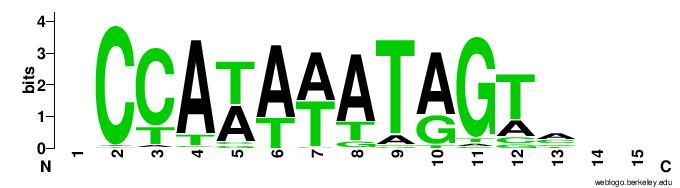

In [17]:
def best_dem(Zi):
    return np.argmax(Zi)

def best_char(p,c):
    return np.argmax(p.T[c])

def get_motifs(seqs,z,p,w):
    motifs=[]
    with open('motifs.fasta','w') as f:
        for i in range(len(seqs)):
            dem = best_dem(z[i])
            motif = seqs[i][dem:dem+w]
            motifs.append(motif)
            f.write(">motif{}\n".format(i))
            f.write(motif+'\n\n')
    return np.array(motifs)

my_motifs = get_motifs(seqs,z,p,w)

from IPython.display import Image
Image(filename='file1400mm.png') 

12\. Comparez les motifs trouvés par votre programme avec les motifs du fichier `testingSequences.txt`, où les vrais motifs sont montrés en lettre majuscule. Quelle est la performance de votre programme? 

In [18]:
true_motifs = []
with open("testingSequences.txt",'r') as f:
    for motif in f:
        motif = "".join(filter(lambda c: c < "a", motif)).strip()
        true_motifs.append(motif)
        
true_motifs = np.array(true_motifs)
corrects = np.where(my_motifs==true_motifs,1,0).sum()
print("Précision de l'algorithme: {}%".format(100*corrects/true_motifs.size) )

ValueError: shape mismatch: objects cannot be broadcast to a single shape